# Évaluation des modèles de classification

## Imports

In [34]:
import os
import torch
import timm
import pandas as pd
import numpy as np
from timm.data.transforms_factory import create_transform
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import ThreeViewsDataset, FrontViewDataset 

## Fonctions

In [2]:
def load_dataset(split_dir, split, test_folds, image_dir, transform):
    test_df = pd.concat([pd.read_csv(os.path.join(split_dir, split, split + f'_fold_{i}.csv')) for i in test_folds], axis=0)
    test_dataset = MyDataset(test_df.values, image_dir, transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    return test_loader

In [3]:
def load_model(model_name, in_channels, num_classes, model_path):
    model = timm.create_model(model_name, pretrained=False, in_chans=in_channels, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()

    return model

In [32]:
def evaluate_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total

    # true_positive_per_class = [0] * model.num_classes
    # targets_per_class = [0] * model.num_classes
    # for pred, targ in zip(list_predictions, list_targets):
    #     targets_per_class[targ] += 1
    #     if pred == targ:
    #         true_positive_per_class[targ] += 1
        
    # recall = mean([tp/tot for tp, tot in zip(true_positive_per_class, targets_per_class)])
    # precision = 

    
    # print('Accuracy: {:.3f}%'.format(accuracy))
    # print('Recall: {:.3f}%'.format(recall))
    # print('Precision: {:.3f}%'.format(precision))
    
    return accuracy, list_predictions, list_targets

In [84]:
def plot_confusion_matrix(predictions, targets):
    index_to_label = {
            0: 'ecto',
            1: 'ecto-meso',
            2: 'meso',
            3: 'meso-endo',
            4: 'endo'
            }

    # Convert numerical predictions and targets to class names
    predictions_class_names = [index_to_label[pred] for pred in predictions]
    targets_class_names = [index_to_label[target] for target in targets]

    # Compute confusion matrix
    cm = confusion_matrix(targets_class_names, predictions_class_names, labels=list(label_to_index.keys()))
    
    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=list(label_to_index.keys()), columns=list(label_to_index.keys()))

    # Calculer l'exactitude
    accuracy = np.trace(cm) / np.sum(cm)

    # # Calculer la précision et le rappel globaux
    # precision_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=0))) / np.diag(cm).shape[0]
    # recall_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=1))) / np.diag(cm).shape[0]
    
    # Afficher les résultats
    print(f'Accuracy: {accuracy:.3f}')
    # print(f'Global Precision: {precision_global:.2f}')
    # print(f'Global Recall: {recall_global:.2f}')

    
    print('---')
    # Calculer la précision et le rappel pour chaque classe
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    
    # Afficher les résultats
    # print(f'Accuracy: {accuracy:.3f}')
    for i, label in enumerate(label_to_index.keys()):
        print(f'{label} - precision: {precision[i]:.3f}, recall: {recall[i]:.3f}')
        # print(f'Precision for {label}: {precision[i]:.3f}')
        # print(f'Recall for {label}: {recall[i]:.3f}')
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## Variables globales

In [39]:
image_dir_batch1 = r'C:\Users\Daniel\Documents\Data\Batch1'
split_dir = r'C:\Users\Daniel\Documents\Workspace\ClinicDataAnalysis\splits'
label_to_index = {
            'ecto': 0, 
            'ecto-meso': 1,
            'meso': 2,
            'meso-endo': 3,
            'endo': 4
            }

index_to_label = {
            0: 'ecto',
            1: 'ecto-meso',
            2: 'meso',
            3: 'meso-endo',
            4: 'endo'
            }

## Evaluations

### ResNet50

#### 001

In [66]:
# Variables
model_name = 'resnet50'
model_path = r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs\resnet50_001\model_epoch_26.pth'
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
log_name = model_name + '_' + '001'
MyDataset = FrontViewDataset
transform = create_transform((3,224,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions1, targets1 = evaluate_model(model, dataloader)

Accuracy: 0.434
---
ecto - precision: 0.485, recall: 0.620
ecto-meso - precision: 0.311, recall: 0.280
meso - precision: 0.395, recall: 0.262
meso-endo - precision: 0.411, recall: 0.311
endo - precision: 0.505, recall: 0.685


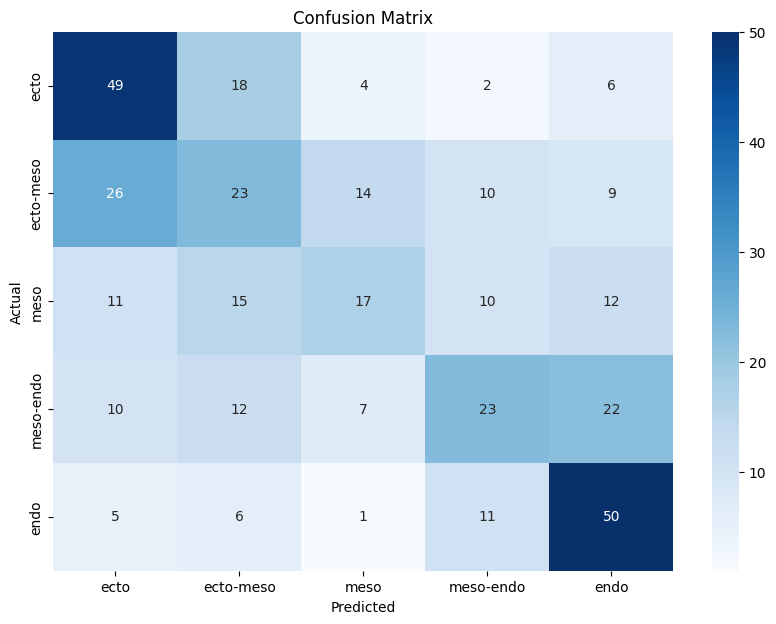

In [85]:
# Trace matrice de confusion
plot_confusion_matrix(predictions1, targets1)

#### 002

In [64]:
# Variables
model_name = 'resnet50'
model_path = r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs\resnet50_002\model_epoch_15.pth'
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
log_name = model_name + '_' + '002'
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions2, targets2 = evaluate_model(model, dataloader)



Accuracy: 0.402
---
ecto - precision: 0.506, recall: 0.532
ecto-meso - precision: 0.297, recall: 0.268
meso - precision: 0.297, recall: 0.169
meso-endo - precision: 0.328, recall: 0.297
endo - precision: 0.473, recall: 0.726


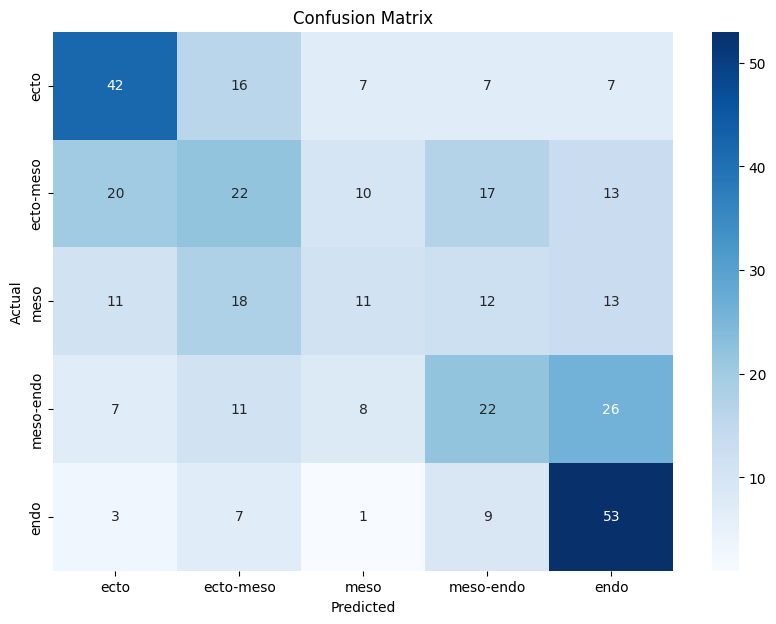

In [86]:
# Trace matrice de confusion
plot_confusion_matrix(predictions2, targets2)

Les tests 001 et 002 semblent atteindre la même conclusion. Avec un simple fine tuning, le modèle semble en difficulté pour correctement classifier les images. Au vu de la matrice de confusion, la classe 'meso' est très mal classifiée. C'est également la classe la moins représentées dans la base de données. On se propose donc dans le test 003 d'utiliser une base de données parfaitement équilibrée. On regardera, lors d'expérimentations futur, le dégèle de l'intégralité du réseau et le traitement des 3 images ou lieu de la première exclusivement. 

#### 003

In [81]:
# Variables
model_name = 'resnet50'
split = "strict_full_balanced"
log_name = model_name + '_' + '003'
weigths = 'model_epoch_19.pth'
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions3, targets3 = evaluate_model(model, dataloader)

Accuracy: 0.443
---
ecto - precision: 0.479, recall: 0.538
ecto-meso - precision: 0.291, recall: 0.246
meso - precision: 0.418, recall: 0.354
meso-endo - precision: 0.373, recall: 0.292
endo - precision: 0.560, recall: 0.785


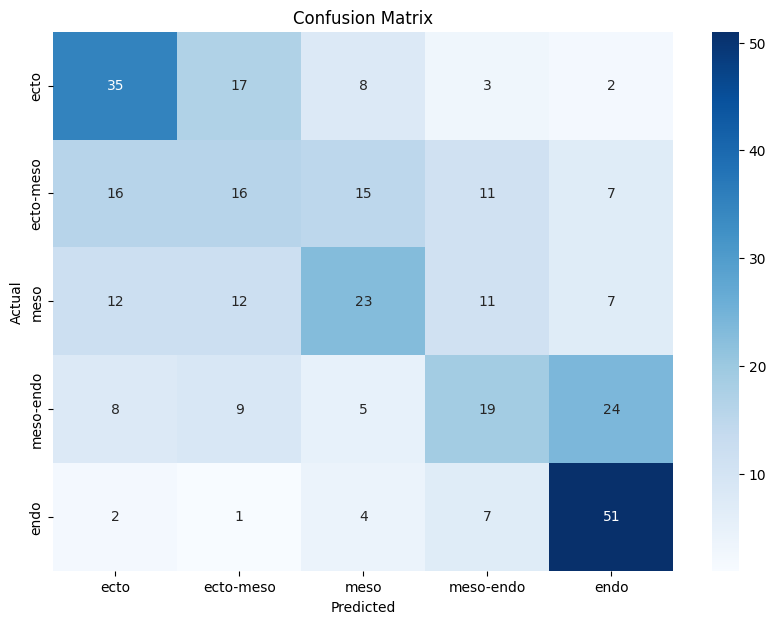

In [87]:
# Trace matrice de confusion
plot_confusion_matrix(predictions3, targets3)

### Mobilenetv2_120d

#### 001

In [90]:
# Variables
model_name = 'mobilenetv2_120d'
split = "strict_full_balanced"
log_name = model_name + '_' + '001'
weigths = 'model_epoch_10.pth'
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0
model_path = os.path.join(r'C:\Users\Daniel\Documents\Workspace\MorphoClassification\runs', log_name, weigths)

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions4, targets4 = evaluate_model(model, dataloader)

Accuracy: 0.338
---
ecto - precision: 0.385, recall: 0.462
ecto-meso - precision: 0.188, recall: 0.200
meso - precision: 0.254, recall: 0.246
meso-endo - precision: 0.415, recall: 0.338
endo - precision: 0.468, recall: 0.446


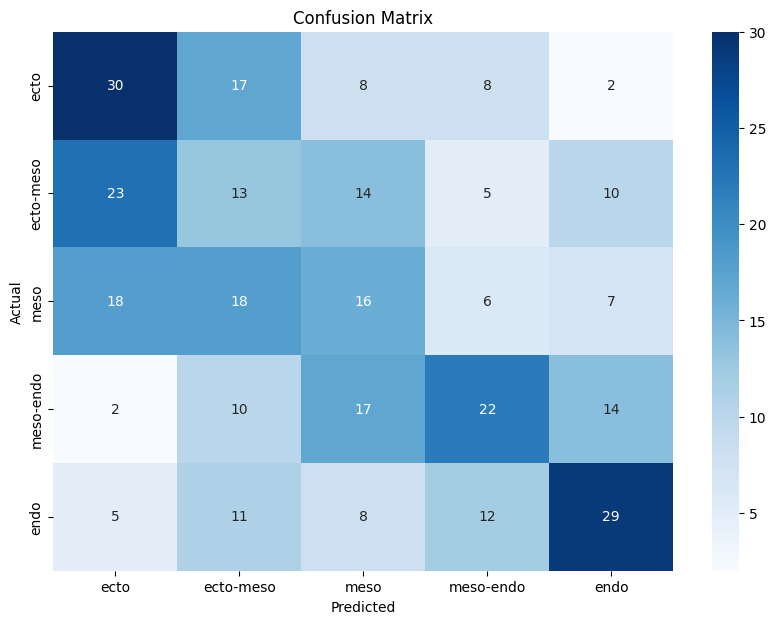

In [91]:
# Trace matrice de confusion
plot_confusion_matrix(predictions4, targets4)